# <ins>Analyzing Energy Consumption and Weather Patterns to Predict Price of Energy in Spain</ins>
#### Group Members: Itzhak Estrella, Alexander Parks, Anthony Rojas, Monique Tran
<img src="andrey-metelev-powergrid.jpg" width="600" height="400" align="center"/>

*(Andrey Matelev, 2021)*


## Summary
---
Initially, we had 6 different datasets – 5 timeseries weather datasets for 5 different cities (Barcelona, Seville, Madrid, Bilbao, and Valencia), all with the same features and times. We also had 1 energy dataset for the entirety of Spain. We combined these datasets, only keeping the records that were in all 6 datasets, into a csv called merged_energy_weather.csv. 

We dropped features that were not needed, such as API-related or forecasted data. We also tried 1 hot encoding, but it expanded our dataset too significantly. In the end, the 2 categorical features that were 1HE were deemed not needed because there was other weather information/weather status features.

For records with missing values, we imputed the data using the average for that feature and dropped the 2 features that were missing entries in all 35,064 records. We eliminated a few outliers in pressure_barcelona because some values appeared erroneous after plotting them in a boxplot. 

We created several different variations of our original dataset. We 1) binned all entries by days, weeks, and months, 2) kept only the features that were highly correlated to the feature we were trying to predict (price actual) that met a certain correlation threshold, and 3) did feature reduction using PCA.

We then determined the best models after performing a nested CV using Gridsearch on 7 different models and picking the top 3 with the highest R2 value to be included in a Voting Regressor Ensemble. However, we found that using just the top 2 highest-performing models worked much better than using the top 3, so we decided on this in the end. 

We used our Voting Regressor with 2 base classifiers on the variations of the original dataset, and it performed best on the dataset where only the features with a correlation >= 0.05 were kept in the dataset, with a final R2 of 93.31%. It performed slightly worse where only features with a correlation >= 0.1, worse when features >= 0.2 were kept in, and significantly worse where features with a correlation >= to 0.3 were kept in with an R2 of 55.30%. It had an R2 of 60.56% on the dataset that was binned by week, performed slightly worse when data was binned by day, and performed significantly worse on dataset binned by year at an R2 of 42.65%.

In conclusion, we believe that including a broader set of features, even those with lower correlation to the target variable, contributes positively to the model's predictive accuracy. Additionally, it appears that looking at data binned by week may yield greater insights for the model than by day or month. We believe the reason why the model performed so much more poorly on the binned by time data is because many features were smoothed and averaged over greater periods of time.


## Introduction
---
The use of Machine Learning and Artificial Intelligence techniques has gained significant importance in recent years, offering a lot of potential in the transition towards renewable and non-renewable energy-based electrical infrastructures. One of the most promising areas for the application of these technologies is the forecasting of energy consumption and generation in energy markets. This project aims to explore a set of comprehensive datasets that contain four years worth of data related to electrical consumption, generation, pricing, and weather conditions in Spain. These sets of datasets are essential for understanding and predicting energy market dynamics and contributing to the transition to sustainable energy sources.

## Dataset Overview:
---
The datasets we are working with here provides valuable information pertaining to the Spanish energy market. The data includes unique attributes/variables such as electrical consumption, generation, pricing, and weather conditions. The following data was gathered from various reputable sources:

- **Electrical Consumption and Generation Data:** This dataset was collected from *European Network of Transmission System Operators for Electricity* (ENTSOE), a public portal for Transmission Service Operator (TSO) data.

- **Settlement Prices:** The settlement prices were obtained from the Spanish TSO, *Red Electric España* (REE).

- **Weather Data:** The weather data for the five largest cities in Spain was sourced from [Open Weather API](https://openweathermap.org/api).

## Objective
---
In this project, we will explore, clean, visualize, and analyze this dataset to gain insights into the energy market in Spain. Our objective is to predict Spain's overall energy price based on specific energy data and weather data. 

In [22]:
# Libraries 
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings

# Models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression

In [23]:
# Read in datasets
energy_file = 'energy_dataset.csv'
weather_file = 'weather_features.csv'

energy_df = pd.read_csv(energy_file)
weather_df = pd.read_csv(weather_file)

# Exploring Energy Data – Overview
---
- This dataframe contains many different types of electrical generation data for the entirety of Spain.
- This dataframe contains one column ('generation hydro pumped storage aggregated') that contains no value.
- This dataframe contains one colum ('generation wind offshore') that contains no unique values other than zero
- The following columns (6/29) except these contain NO missing values: 
    'time', 'forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast', 'price day ahead', 'price actual' 
- All energy data is presented as float type

#### Units of Measurement for Energy Parameters
- Price actual is presented as EUR/MWh
- All variety of generations are presented as MW

In [302]:
energy_df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [303]:
print('Shape of Energy Dataset {}\n'.format(energy_df.shape))
print(energy_df.info())

Shape of Energy Dataset (35064, 29)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal              

# Exploring Weather Data – Overview
---
- This dataframe contains precipitation, wind, and other weather conditions for 
  five major cities in Spain.
- This dataframe contains no missing (NULL) values
- Data types present in this dataframe: float(6), int(6), string objects(5)

#### Units of Measurement for Weather Parameters
| Attribute            | Unit Measurement           |
|----------------------|---------------------------|
| temp                 | °K (Kelvin)              |
| pressure             | hPa (Hectopascal)          |
| humidity             | % (Percentage)            |
| wind_speed           | m/s (Meters per second)   |
| wind_deg             | ° (Degrees)               |
| rain_1h              | mm/h (Millimeters per hour)          |
| rain_3h              | mm (Millimeters)          |
| snow_3h              | mm (Millimeters)          |
| clouds_all           | % (Percentage)            |

[Source](https://openweathermap.org/weather-data)

In [25]:
print('Our Given Five Spanish Cities:', weather_df['city_name'].unique())
weather_df.head()

Our Given Five Spanish Cities: ['Valencia' 'Madrid' 'Bilbao' ' Barcelona' 'Seville']


,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [305]:
print('Shape of Weather Dataset {}\n'.format(weather_df.shape))
print(weather_df.info())

Shape of Weather Dataset (178396, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 n

## Merging the Datasets
---
First, we check the size of each weather dataframe within each Spanish city.

In [26]:
# Valencia
w_valencia_df = weather_df[weather_df['city_name'] == 'Valencia']
print('Valencias Weather Shape:', w_valencia_df.shape)

# Madrid
w_madrid_df =  weather_df[weather_df['city_name'] == 'Madrid']
print('Madrid Weather Shape:', w_madrid_df.shape)

# Bilbao
w_bilbao_df = weather_df[weather_df['city_name'] == 'Bilbao']
print('Bilbao Weather Shape:', w_bilbao_df.shape)

# Barcelona
w_barcelona_df = weather_df[weather_df['city_name'] == ' Barcelona']
print('Barcelona Weather Shape:', w_barcelona_df.shape)

# Seville
w_seville_df = weather_df[weather_df['city_name'] == 'Seville']
print('Seville Weather Shape:', w_seville_df.shape)

Valencias Weather Shape: (35145, 17)
Madrid Weather Shape: (36267, 17)
Bilbao Weather Shape: (35951, 17)
Barcelona Weather Shape: (35476, 17)
Seville Weather Shape: (35557, 17)


We realized that not all of these datasets did not contain the same amount of entries, which was because they all didn't contain the same dates (some were missing in some specific dataframes).

We checked if all the datasets start and end at the same time, which they do.
We used set comparisons to find the elements that were in common between all five
cities' weather data, aka the intersection, and modified each of the five dataframes
to only contain data that was found in the intersection.

In [28]:
# Lets check if they start and end with the same data + time
print('Start at same time?', w_valencia_df['dt_iso'].iloc[0] == w_madrid_df['dt_iso'].iloc[0] == w_bilbao_df['dt_iso'].iloc[0] == w_barcelona_df['dt_iso'].iloc[0] == w_seville_df['dt_iso'].iloc[0])
print('End at same time?', w_valencia_df['dt_iso'].iloc[-1] == w_madrid_df['dt_iso'].iloc[-1] == w_bilbao_df['dt_iso'].iloc[-1] == w_barcelona_df['dt_iso'].iloc[-1] == w_seville_df['dt_iso'].iloc[-1])
# All start at the same date + time AND end at the same date + time

# Now lets use set comparisons
set_valencia = set(w_valencia_df['dt_iso'])
set_madrid = set(w_madrid_df['dt_iso'])
set_bilbao = set(w_bilbao_df['dt_iso'])
set_barcelona = set(w_barcelona_df['dt_iso'])
set_seville = set(w_seville_df['dt_iso'])

sets = [set_valencia, set_madrid, set_bilbao, set_barcelona, set_seville]

# Calculate the intersection of all sets
intersection_dt = set_valencia.intersection(set_madrid,set_bilbao, set_barcelona, set_seville)

# Modify each set to only contain elements in the intersection
for s in sets:
    s.intersection_update(intersection_dt)

# Print the modified sets
for i, s in enumerate(sets, start=1):
    print(f"Set {i}: {len(s)}")

print(len(intersection_dt)) 

Start at same time? True
End at same time? True
Set 1: 35064
Set 2: 35064
Set 3: 35064
Set 4: 35064
Set 5: 35064
35064


We removed duplicates from the sets. Now, each of the five dataframes contained
the same records and number of features. They're ready to be merged!

In [29]:
# Valencia
w_valencia_df = w_valencia_df[w_valencia_df['dt_iso'].isin(intersection_dt)]
w_valencia_df = w_valencia_df.drop_duplicates(subset=['dt_iso'])

# Madrid
w_madrid_df = w_madrid_df[w_madrid_df['dt_iso'].isin(intersection_dt)]
w_madrid_df = w_madrid_df.drop_duplicates(subset=['dt_iso'])

# Bilbao
w_bilbao_df = w_bilbao_df[w_bilbao_df['dt_iso'].isin(intersection_dt)]
w_bilbao_df = w_bilbao_df.drop_duplicates(subset=['dt_iso'])

# Barcelona
w_barcelona_df = w_barcelona_df[w_barcelona_df['dt_iso'].isin(intersection_dt)]
w_barcelona_df = w_barcelona_df.drop_duplicates(subset=['dt_iso'])

# Seville
w_seville_df = w_seville_df[w_seville_df['dt_iso'].isin(intersection_dt)]
w_seville_df = w_seville_df.drop_duplicates(subset=['dt_iso'])


print('Valenci\'as Weather Shape:', w_valencia_df.shape)
print('Madrid\'s Weather Shape:', w_madrid_df.shape)
print('Bilbao\'s Weather Shape:', w_bilbao_df.shape)
print('Seville\'s Weather Shape:', w_seville_df.shape)
print('Barcelona\'s Weather Shape:', w_barcelona_df.shape)

Valenci'as Weather Shape: (35064, 17)
Madrid's Weather Shape: (35064, 17)
Bilbao's Weather Shape: (35064, 17)
Seville's Weather Shape: (35064, 17)
Barcelona's Weather Shape: (35064, 17)


Before we merge, we cleaned up the energy dataset too. We only used the times
that all the five cities also have in common, aka we ensured all the records
are the same in the energy dataset as well.

In [30]:
# Now lets shrink the energy dataset with the intersection dates
new_energy_df = energy_df[energy_df['time'].isin(intersection_dt)]
new_energy_df = new_energy_df.drop_duplicates(subset=['time'])

print('New Energy Shape:', new_energy_df.shape)

New Energy Shape: (35064, 29)


We merged all 6 datasets by the time feature.

In [31]:
# List of new weather dataframes that we shrunk
merging_dataframes = [new_energy_df, w_valencia_df, w_barcelona_df, w_bilbao_df, w_madrid_df, w_seville_df]

# Rename all dataframes so that each col has city in feature name
w_valencia_df.columns = [col + "_valencia" if col != 'dt_iso' else col for col in w_valencia_df.columns]
w_barcelona_df.columns = [col + "_barcelona" if col != 'dt_iso' else col for col in w_barcelona_df.columns]
w_seville_df.columns = [col + "_seville" if col != 'dt_iso' else col for col in w_seville_df.columns]
w_bilbao_df.columns = [col + "_bilbao" if col != 'dt_iso' else col for col in w_bilbao_df.columns]
w_madrid_df.columns = [col + "_madrid" if col != 'dt_iso' else col for col in w_madrid_df.columns]

# Merge all datasets with each other
merged_dataset = w_valencia_df.merge(w_barcelona_df, on='dt_iso', how='left')
merged_dataset = merged_dataset.merge(w_bilbao_df, on='dt_iso', how='left')
merged_dataset = merged_dataset.merge(w_madrid_df, on='dt_iso', how='left')
merged_dataset = merged_dataset.merge(w_seville_df, on='dt_iso', how='left')

# Rename energy's time feature to dt_iso
new_energy_df = new_energy_df.rename(columns={'time': 'dt_iso'})

# Merge energy with all 5 weather dataframes
merged_dataset = merged_dataset.merge(new_energy_df, on='dt_iso', how='left')

print('Shape of new merged dataset:', merged_dataset.shape)

merged_dataset.head()

Shape of new merged dataset: (35064, 109)


,dt_iso,city_name_valencia,temp_valencia,temp_min_valencia,temp_max_valencia,pressure_valencia,humidity_valencia,wind_speed_valencia,wind_deg_valencia,rain_1h_valencia,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


We don't need the city name anymore since it's already in the features' names, which
we added as a result of merging.

In [32]:
# Repetitive information since every feature for weather per city has city name in feature name
columns_to_drop = ['city_name_madrid', 'city_name_bilbao', 'city_name_barcelona', 'city_name_seville', 'city_name_valencia', 'temp_min_valencia', 'temp_max_valencia',
                   'temp_min_seville', 'temp_max_seville', 'temp_min_madrid', 'temp_max_madrid', 'temp_min_barcelona', 'temp_max_barcelona', 'temp_min_bilbao', 'temp_max_bilbao']
merged_dataset = merged_dataset.drop(columns=columns_to_drop)
merged_dataset.head()

# Create and download this csv, comment out after it's done so it's not repeated every time code is run
# merged_dataset.to_csv('merged_energy_weather.csv', index=False)

,dt_iso,temp_valencia,pressure_valencia,humidity_valencia,wind_speed_valencia,wind_deg_valencia,rain_1h_valencia,rain_3h_valencia,snow_3h_valencia,clouds_all_valencia,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,270.475,1001,77,1,62,0.0,0.0,0.0,0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,270.475,1001,77,1,62,0.0,0.0,0.0,0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,269.686,1002,78,0,23,0.0,0.0,0.0,0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,269.686,1002,78,0,23,0.0,0.0,0.0,0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,269.686,1002,78,0,23,0.0,0.0,0.0,0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


# Data Cleaning
---
We dropped data that is not relevant/useful for our model (this information is API related and not useful to us).

In [33]:
# Not needed information
merged_dataset = merged_dataset.drop(['weather_icon_valencia'], axis=1)
merged_dataset = merged_dataset.drop(['weather_icon_bilbao'], axis=1)
merged_dataset = merged_dataset.drop(['weather_icon_madrid'], axis=1)
merged_dataset = merged_dataset.drop(['weather_icon_seville'], axis=1)
merged_dataset = merged_dataset.drop(['weather_icon_barcelona'], axis=1)

We did hot encoding for all the categorical variables on a separate dataset - we
wanted to see how much it expands our dataset by, since there are five cities and 
many different types of entries in both weather description and weather main. We
wanted to determine if they were worth keeping in.

In [34]:
OHE_merged_dataset = merged_dataset

OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_description_valencia'])
OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_main_valencia'])
OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_description_seville'])
OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_main_seville'])
OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_description_barcelona'])
OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_main_barcelona'])
OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_description_madrid'])
OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_main_madrid'])
OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_description_bilbao'])
OHE_merged_dataset = pd.get_dummies(OHE_merged_dataset, columns=['weather_main_bilbao'])

Then, we looked at the correlation of all features to each other and see which
ones we can drop because they give us the same information.

In [36]:
# Calculate the correlation matrix
corr_matrix = OHE_merged_dataset.drop(columns='dt_iso').corr()

# Set a correlation threshold for considering values as highly correlated
correlation_threshold = 0.9 

# Find highly correlated pairs
highly_correlated_pairs = []

# Iterate through the correlation matrix
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
            pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            highly_correlated_pairs.append(pair)

# Print highly correlated pairs
print("Highly Correlated Pairs:")
for pair in highly_correlated_pairs:
    print(pair)

print()
print('Number of features with one-hot-encoded dataset:', len(OHE_merged_dataset.columns))
print('Number of features with original merged dataset:', len(merged_dataset.columns))

Highly Correlated Pairs:
('temp_valencia', 'temp_barcelona', 0.9175055701292095)
('temp_valencia', 'temp_madrid', 0.9122808896039558)
('temp_barcelona', 'temp_madrid', 0.9039959494830991)
('temp_madrid', 'temp_seville', 0.9094213472651101)
('generation solar', 'forecast solar day ahead', 0.9932644415637772)
('generation wind onshore', 'forecast wind onshore day ahead', 0.9944591935562195)
('total load forecast', 'total load actual', 0.9951389210060556)
('weather_description_valencia_fog', 'weather_main_valencia_fog', 1.0)
('weather_description_valencia_haze', 'weather_main_valencia_haze', 1.0)
('weather_description_valencia_light intensity drizzle', 'weather_main_valencia_drizzle', 0.9339116551720713)
('weather_description_valencia_mist', 'weather_main_valencia_mist', 1.0)
('weather_description_valencia_sky is clear', 'weather_main_valencia_clear', 1.0)
('weather_description_valencia_smoke', 'weather_main_valencia_smoke', 1.0)
('weather_description_seville_dust', 'weather_main_seville_

We see that nearly all the weather_main and weather_descriptions for all the cities
have a 1.0 or 0.99 correlation. If we removed only the features that were transformed as a result
of the one hot encoding in the weather_description column, this would leave us with SOME values remaining
in the column that had < 0.9 correlation. We don't want partial data, so we will remove the entire weather
description column. Additionally, just leaving in the one hot encoding expansion of weather main increases
the number of features we have from 89 to 126. Therefore, we will drop this feature too and leave only
numerical features in our dataset. Because this dataset is being used for regression and we have other
numeric values that describe the precipitation, windspeed, etc. as well as weather_id, which is a number code that corresponds to the state of the weather that day, we figured it was okay to drop these values.

Therefore, we will disregard the OHE_merged_dataset and continue with the dataset as we had it prior to OHE (one hot encoding).

We will also drop all other features that had a ~0.995 correlation to other features. They are also forecasted features, which we don't want to use in our model.


In [37]:
# Drop the columns that have 1.0 or 0.99 correlation to each other
merged_dataset = merged_dataset.drop(['weather_description_valencia'], axis=1)
merged_dataset = merged_dataset.drop(['weather_main_valencia'], axis=1)
merged_dataset = merged_dataset.drop(['weather_description_seville'], axis=1)
merged_dataset = merged_dataset.drop(['weather_main_seville'], axis=1)
merged_dataset = merged_dataset.drop(['weather_description_barcelona'], axis=1)
merged_dataset = merged_dataset.drop(['weather_main_barcelona'], axis=1)
merged_dataset = merged_dataset.drop(['weather_description_madrid'], axis=1)
merged_dataset = merged_dataset.drop(['weather_main_madrid'], axis=1)
merged_dataset = merged_dataset.drop(['weather_description_bilbao'], axis=1)
merged_dataset = merged_dataset.drop(['weather_main_bilbao'], axis=1)

# These are forecasted features AND have a ~0.995 correlation to their respective inline comment feature
merged_dataset = merged_dataset.drop(['forecast solar day ahead'], axis=1) # generation solar
merged_dataset = merged_dataset.drop(['forecast wind onshore day ahead'], axis=1) # generation wind onshore
merged_dataset = merged_dataset.drop(['total load forecast'], axis=1) # total load actual

# We don't want forecasted features, not useful to us
merged_dataset = merged_dataset.drop(['price day ahead'], axis=1) # total load actual

Now, let's look at all columns with missing values.

In [38]:
missing_values = merged_dataset.isnull()

# Count the number of missing values per column
num_missing_per_column = missing_values.sum()

# Filter and print only the columns with missing values
missing_columns = num_missing_per_column[num_missing_per_column > 0]
print("Columns with Missing Values:")
print(missing_columns)

Columns with Missing Values:
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                                  18
generation waste 

After some investigation, we can see that there are 17-19 records that contain
several consecutive missing values, i.e. they have no information across several features. Maybe a storm occurred that
tampered with data collection, or the data collection was faulty that day?

In [39]:
missing_indices = merged_dataset[merged_dataset['generation biomass'].isna()].index

# Print the record IDs (indices) with missing values 
print(f"Record IDs with missing values for {'generation biomass'}:")
print(missing_indices)

missing_indices = merged_dataset[merged_dataset['generation fossil brown coal/lignite'].isna()].index

# Print the record IDs (indices) with missing values 
print(f"Record IDs with missing values for {'generation fossil brown coal/lignite'}:")
print(missing_indices)

missing_indices = merged_dataset[merged_dataset['generation marine'].isna()].index

# Print the record IDs (indices) with missing values
print(f"Record IDs with missing values for {'generation marine'}:")
print(missing_indices)

# There are several records that are missing a contiguous set of features, but we will impute these anyways

Record IDs with missing values for generation biomass:
Index([   99,   108,   109,   110,   111,   112,   113,   451,   452,   643,
         661,  2528,  2708,  3968,  6586,  8049, 13341, 16612, 30896],
      dtype='int64')
Record IDs with missing values for generation fossil brown coal/lignite:
Index([   99,   108,   109,   110,   111,   112,   113,   451,   452,   643,
         661,  2528,  2708,  3968,  6586,  8049, 13341, 30896],
      dtype='int64')
Record IDs with missing values for generation marine:
Index([   99,   108,   109,   110,   111,   112,   113,   451,   452,   643,
         661,  2528,  2708,  3968,  6586,  8049, 13341, 15598, 30896],
      dtype='int64')


We still want to impute these values because we consider each entry critical, 
considering this is a time series dataset. We will impute the missing values using the respective
feature's average value.

In [40]:
# Convert "dt_iso" to a recognized datetime format
# changes time zone from CET to UTC (+01:00 to +:00:00)
# same time though just time zone changed for grouping by date
merged_dataset['dt_iso'] = pd.to_datetime(merged_dataset['dt_iso'], utc=True)

# List of columns to impute missing values
columns_to_process = [
    'generation biomass',
    'generation fossil brown coal/lignite',
    'generation fossil coal-derived gas',
    'generation fossil gas',
    'generation fossil hard coal',
    'generation fossil oil',
    'generation fossil oil shale',
    'generation fossil peat',
    'generation geothermal',
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage',
    'generation hydro water reservoir',
    'generation marine',
    'generation nuclear',
    'generation other',
    'generation other renewable',
    'generation waste',
    'generation wind offshore',
    'generation wind onshore',
    'forecast wind offshore eday ahead',
    'total load actual',
    'generation solar'
]

# Calculate and fill missing values for each column
for column in columns_to_process:
    daily_averages = merged_dataset.groupby(merged_dataset['dt_iso'].dt.date)[column].transform('mean')
    merged_dataset[column].fillna(daily_averages, inplace=True)

Now let's look at the missing values again. We see that there are two features
that are completely missing all values! We decided to completely drop them.

In [41]:
missing_values = merged_dataset.isnull()

# Count the number of missing values per column
num_missing_per_column = missing_values.sum()

# Filter and print only the columns with missing values
missing_columns = num_missing_per_column[num_missing_per_column > 0]
print("Columns with Missing Values:")
print(missing_columns)

# Drop the last two columns who are missing entires in all its records
merged_dataset = merged_dataset.drop(['generation hydro pumped storage aggregated'], axis=1)
merged_dataset = merged_dataset.drop(['forecast wind offshore eday ahead'], axis=1)

Columns with Missing Values:
generation hydro pumped storage aggregated    35064
forecast wind offshore eday ahead             35064
dtype: int64


### Summary of our data cleaning process
We have successfully:
1) dropped features that were not useful (API scraping related) for our
model to predict on
2) drooped the categorical variables which added too many features and were highly
correlated with each other (gave us the same type of information)
3) dropped numeric features
that were highly correlated with each other
4) imputed using average for missing values
5) dropped the features that were missing entries for all records.


In [42]:
print('Final number of features of our merged dataset after cleaning it:', len(merged_dataset.columns))

Final number of features of our merged dataset after cleaning it: 73


# Consideration of Outliers
---

In [43]:
# We don't want to consider the first column (dt_iso), remove it
numerical_dataset = merged_dataset.iloc[:,1:]

display(numerical_dataset.head())

,temp_valencia,pressure_valencia,humidity_valencia,wind_speed_valencia,wind_deg_valencia,rain_1h_valencia,rain_3h_valencia,snow_3h_valencia,clouds_all_valencia,weather_id_valencia,...,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,total load actual,price actual
0,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,...,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,25385.0,65.41
1,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,...,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,24382.0,64.92
2,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,...,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,22734.0,64.48
3,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,...,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,21286.0,59.32
4,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,...,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,20264.0,56.04


Below, we have displayed a box and whisker plot for every numerical column.
The plots above show that there are outliers in the data.

However, the presence of some of these outliers makes sense. For instance it does
not rain or snow for most of the year, so any days that have rain or snowfall would
be considered outliers.

However, we feel that it is likely not a good idea to completely get rid
of these datapoints, since rain or snow could give us valuable insight into
the energy price.

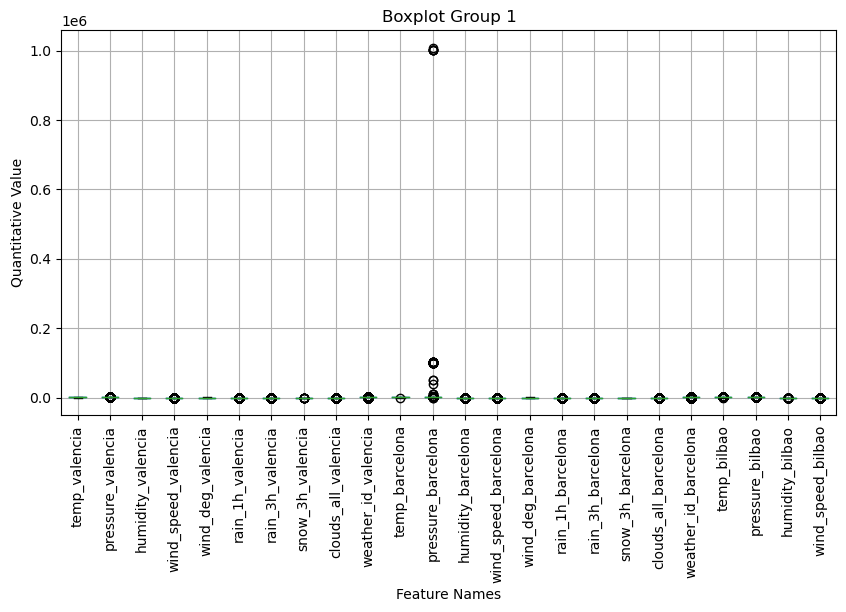

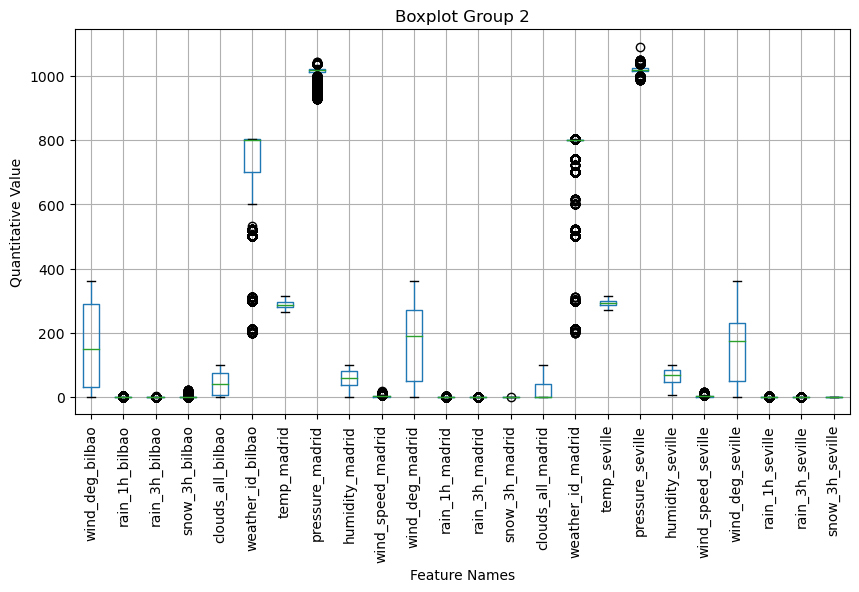

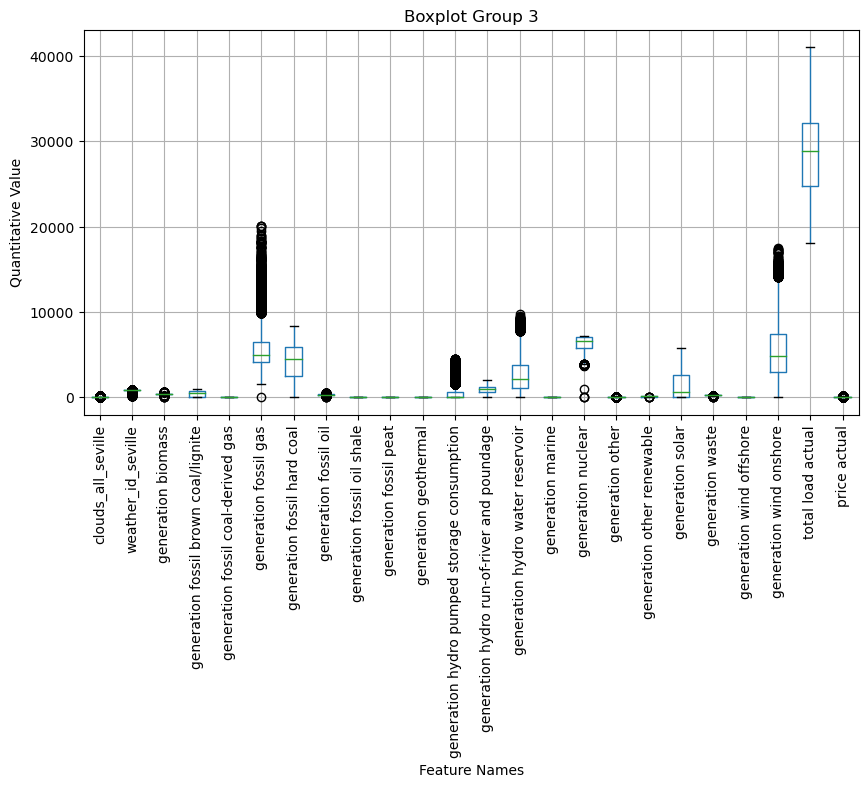

In [44]:
# Split all the features into groups of 3
feature_groups = [numerical_dataset.columns[i:i+24] for i in range(0, 72, 24)]

# Create a separate boxplot for each group
for i, feature_group in enumerate(feature_groups):
    fig, ax = plt.subplots(figsize=(10, 5))
    numerical_dataset[feature_group].boxplot(ax=ax)
    ax.set_title(f"Boxplot Group {i+1}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_ylabel("Quantitative Value")  
    ax.set_xlabel("Feature Names")  
    plt.show()

One feature that did cause concern for us was "pressure_barcelona". It seems that there might be erroneous values that are way over what is typical (3 orders of magnitude larger than even the 75th percentile).

To confirm this, we went back to the original dataset. Only 45 values have pressures over 1100 hPa. All of them were in
Barcelona over the course of 3 days. Some of the values were unreasonable and didn't make sense. For instance, the pressure jumped from 100211 hPA to 1002241 hPA over the course of an hour (which seems very unreasonable) for a record that we looked at.

Because of this, we believe it is safe to assume that any pressure of over 1100 hPA in Barcelona is erroneous. We will remove these values from our dataset.

In [45]:
numerical_dataset['pressure_barcelona'].describe()

huge_pressure_values = weather_df[weather_df['pressure'] > 1100]
print("Number of datapoints with pressure over 1.1k (all in Barcelona):", huge_pressure_values.shape[0])
display(huge_pressure_values.head(15))

Number of datapoints with pressure over 1.1k (all in Barcelona): 45


,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
108572,2015-02-20 09:00:00+01:00,Barcelona,284.360000,284.360000,284.360000,102153,0,1,275,0.0,0.0,0.0,0,800,clear,sky is clear,01d
108573,2015-02-20 10:00:00+01:00,Barcelona,286.360000,286.360000,286.360000,102132,0,1,275,0.0,0.0,0.0,0,800,clear,sky is clear,01d
108574,2015-02-20 11:00:00+01:00,Barcelona,286.050000,286.050000,286.050000,102075,0,2,67,12.0,0.0,0.0,0,503,rain,very heavy rain,10d
108575,2015-02-20 12:00:00+01:00,Barcelona,286.050000,286.050000,286.050000,101983,0,2,219,0.0,0.0,0.0,0,800,clear,sky is clear,01d
108576,2015-02-20 13:00:00+01:00,Barcelona,286.960000,286.960000,286.960000,101921,0,1,67,0.0,0.0,0.0,0,800,clear,sky is clear,01d
108577,2015-02-20 14:00:00+01:00,Barcelona,277.050000,277.050000,277.050000,101756,0,1,67,0.0,0.0,0.0,0,800,clear,sky is clear,01d
108578,2015-02-20 15:00:00+01:00,Barcelona,286.750000,286.750000,286.750000,10163,0,1,292,0.0,0.0,0.0,0,800,clear,sky is clear,01d
108579,2015-02-20 16:00:00+01:00,Barcelona,286.850000,286.850000,286.850000,101574,0,1,315,0.0,0.0,0.0,0,800,clear,sky is clear,01d
108581,2015-02-20 18:00:00+01:00,Barcelona,285.450000,285.450000,285.450000,10145,0,1,67,0.0,0.0,0.0,8,800,clear,sky is clear,02d
108582,2015-02-20 19:00:00+01:00,Barcelona,281.723313,281.723313,281.723313,40542,0,1,67,0.0,0.0,0.0,21,801,clouds,few clouds,02


Remove the erroneous values from our dataset.

In [46]:
old_datapoint_count = merged_dataset.shape[0]

merged_dataset = merged_dataset[merged_dataset['pressure_barcelona'] <= 1100]

display(merged_dataset.head())

# Confirm that we indeed got rid all of the erroneous days
new_datapoint_count = merged_dataset.shape[0]

print("Items Removed:", old_datapoint_count - new_datapoint_count)

,dt_iso,temp_valencia,pressure_valencia,humidity_valencia,wind_speed_valencia,wind_deg_valencia,rain_1h_valencia,rain_3h_valencia,snow_3h_valencia,clouds_all_valencia,...,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,total load actual,price actual
0,2014-12-31 23:00:00+00:00,270.475,1001,77,1,62,0.0,0.0,0.0,0,...,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,25385.0,65.41
1,2015-01-01 00:00:00+00:00,270.475,1001,77,1,62,0.0,0.0,0.0,0,...,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,24382.0,64.92
2,2015-01-01 01:00:00+00:00,269.686,1002,78,0,23,0.0,0.0,0.0,0,...,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,22734.0,64.48
3,2015-01-01 02:00:00+00:00,269.686,1002,78,0,23,0.0,0.0,0.0,0,...,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,21286.0,59.32
4,2015-01-01 03:00:00+00:00,269.686,1002,78,0,23,0.0,0.0,0.0,0,...,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,20264.0,56.04


Items Removed: 45


When looking at the distribution of the class label (price actual), it does seem to
have a good amount of variance. Because of this, performing machine learning on this
feature makes sense and we think it will lead to interesting conclusions.

Text(0.5, 0, 'EUR/MWh')

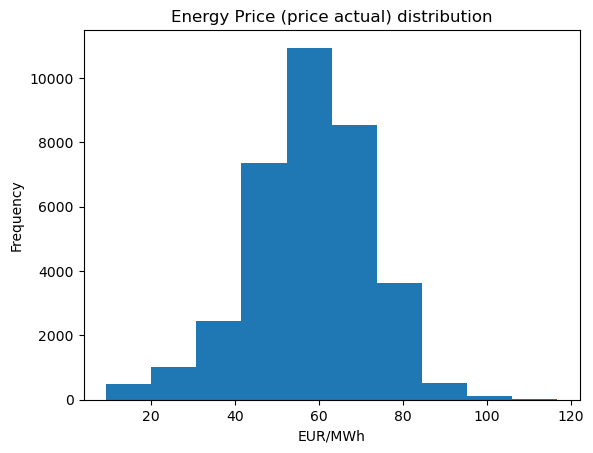

In [47]:
plt.figure()
plt.title('Energy Price (price actual) distribution')
numerical_dataset.iloc[:,-1].plot(kind='hist')
plt.xlabel('EUR/MWh')

# Data Visualizations
---
Now, we are going to look at some graphs of our data to see if the trends make sense
and also to just get a better understanding of what is happening within the dataset.
We will start by binning the data by day, week, month, and year.

In [48]:
merged_dataset.set_index('dt_iso', inplace=True)

# Resample and calculate the mean for day, week, month, and year
daily_df = merged_dataset.resample('D').mean()
weekly_df = merged_dataset.resample('W').mean()
monthly_df = merged_dataset.resample('M').mean()
yearly_df = merged_dataset.resample('Y').mean()

print('Shape of daily dataset:', daily_df.shape)
print('Shape of weekly dataset:', weekly_df.shape)
print('Shape of monthly dataset:', monthly_df.shape)
print('Shape of yearly dataset:', yearly_df.shape)

Shape of daily dataset: (1462, 72)
Shape of weekly dataset: (210, 72)
Shape of monthly dataset: (49, 72)
Shape of yearly dataset: (5, 72)


We wanted to visualize the price actual feature, or the feature that we want to make predictions on. Here is the visualization of the price of energy in Euros/MWh, for five years across all of Spain.

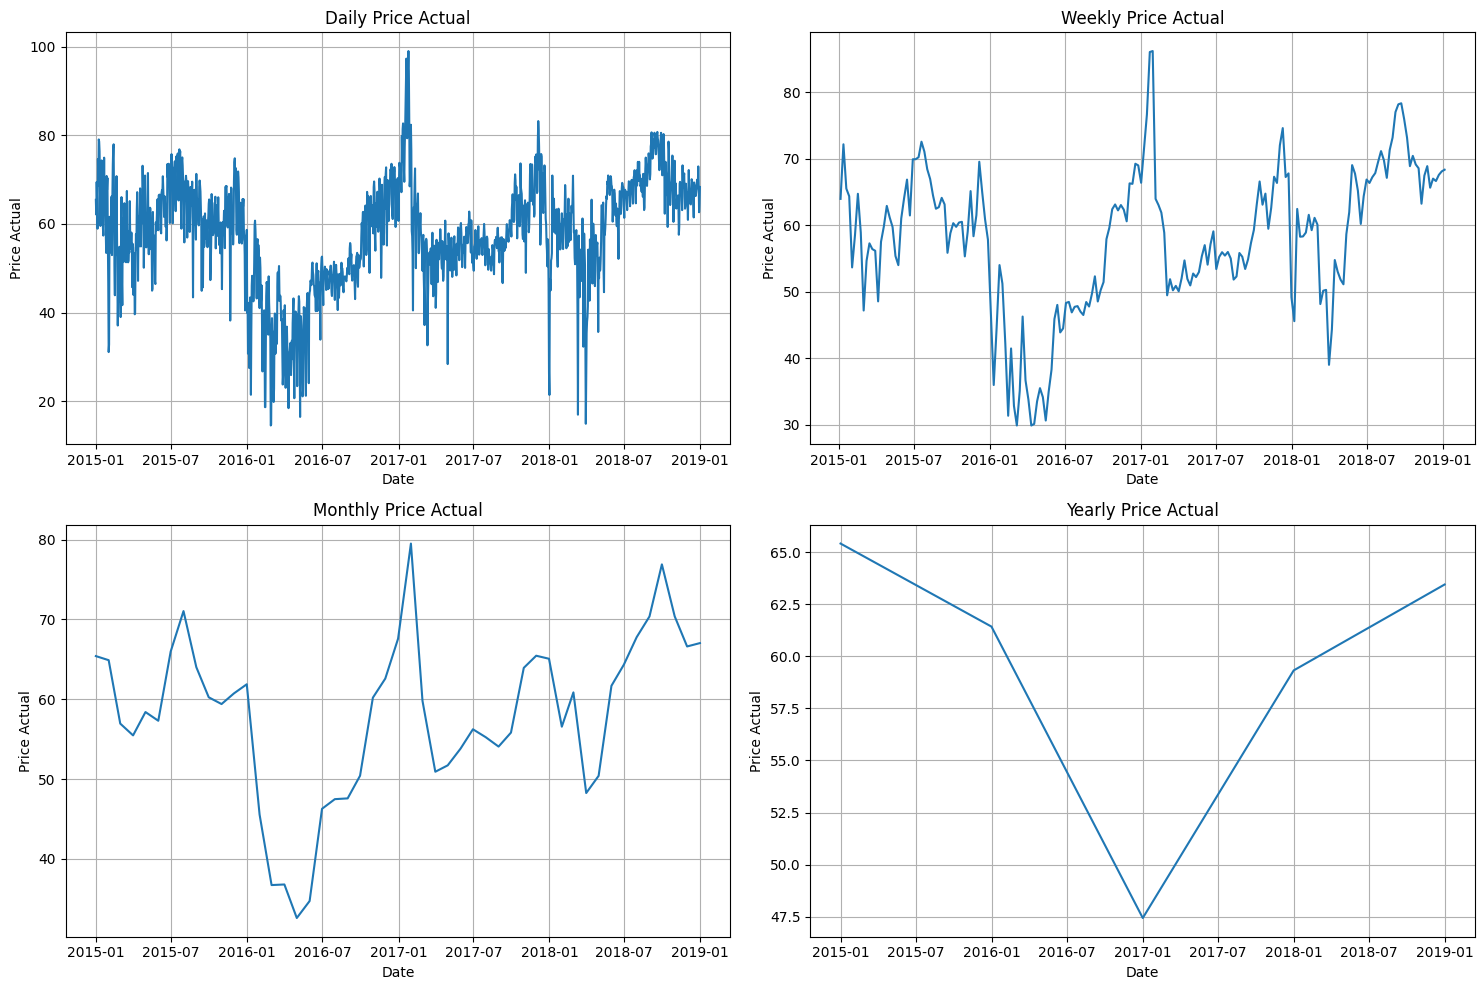

In [327]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].plot(daily_df.index, daily_df['price actual'])
axs[0, 0].set_title('Daily Price Actual')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Price Actual')
axs[0, 0].grid()

axs[0, 1].plot(weekly_df.index, weekly_df['price actual'])
axs[0, 1].set_title('Weekly Price Actual')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Price Actual')
axs[0, 1].grid()

axs[1, 0].plot(monthly_df.index, monthly_df['price actual'])
axs[1, 0].set_title('Monthly Price Actual')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Price Actual')
axs[1, 0].grid()

axs[1, 1].plot(yearly_df.index, yearly_df['price actual'])
axs[1, 1].set_title('Yearly Price Actual')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Price Actual')
axs[1, 1].grid()

plt.tight_layout()
plt.show()

We see that there is a sharp decrease in the summer of 2016, a sharp increase mid-winter of 2017, and a steady increase until 2019. Global warming might've been especially significant between 2016-2017.

Let's also take a look at how each variable correlates with each other, and also with the target variable to see if there are any interesting trends.

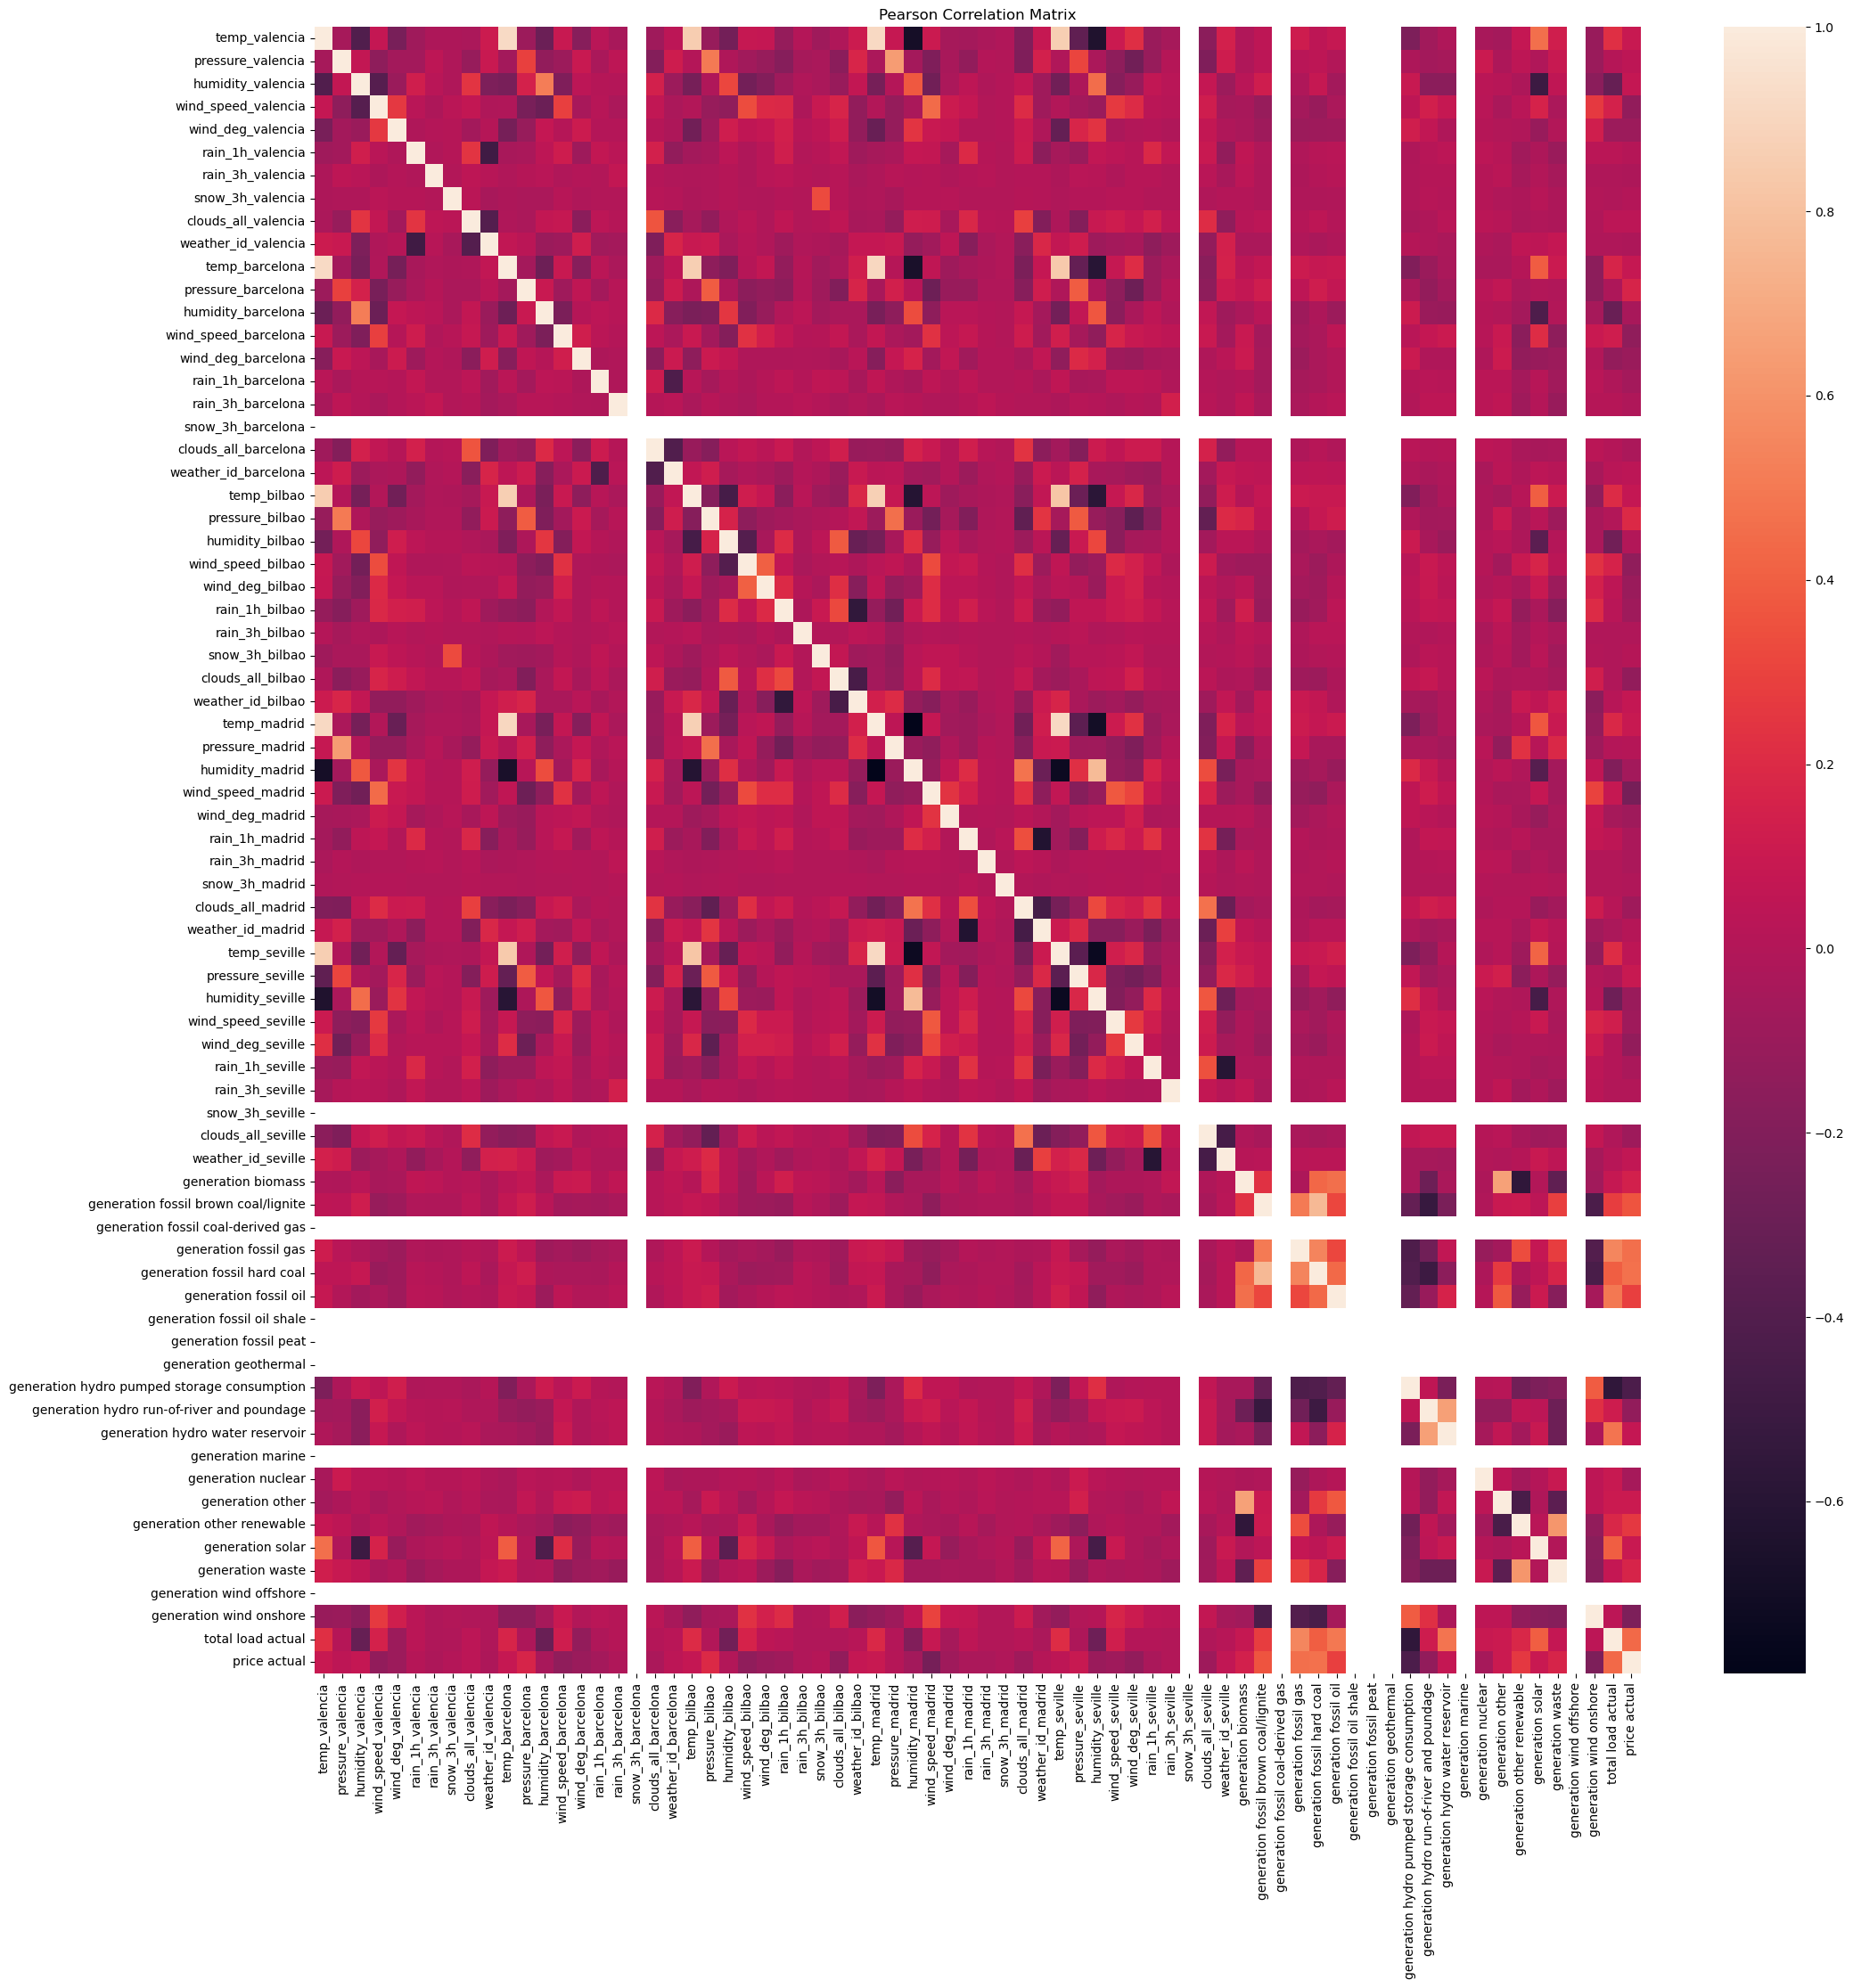

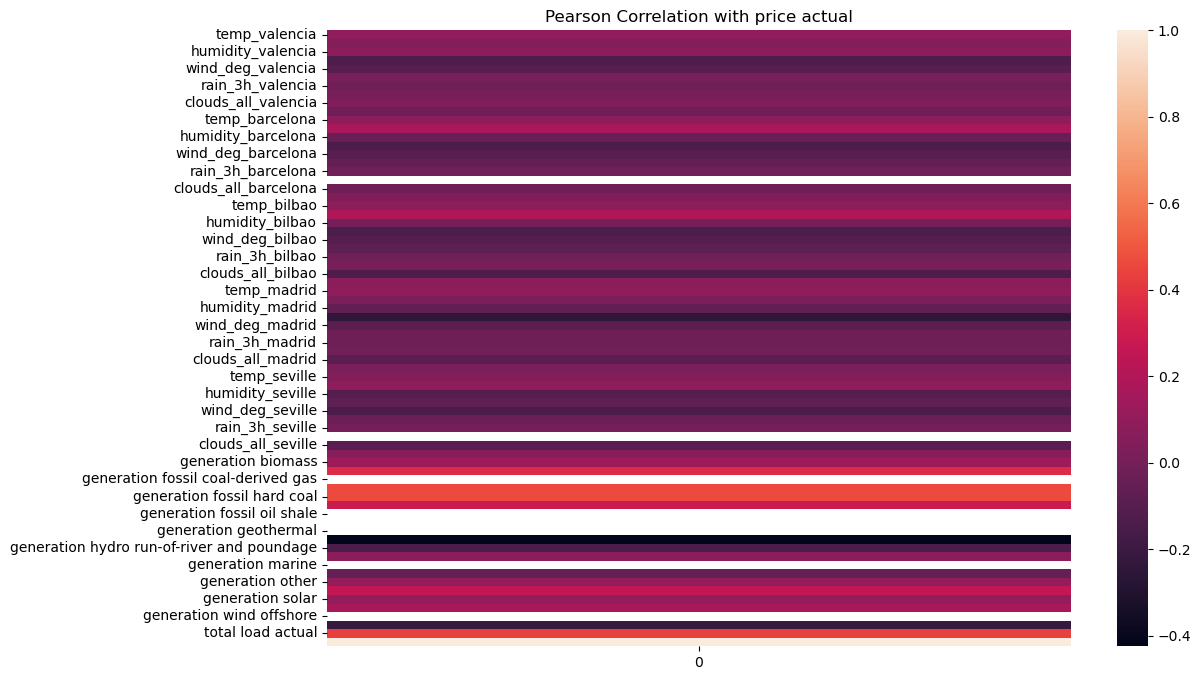

Top 10 features with the highest correlation with price actual:
price actual                                   1.000000
generation fossil hard coal                    0.464673
generation fossil gas                          0.460929
total load actual                              0.435302
generation hydro pumped storage consumption    0.424651
generation fossil brown coal/lignite           0.363082
generation fossil oil                          0.283637
generation other renewable                     0.254652
wind_speed_madrid                              0.244923
generation wind onshore                        0.219089
dtype: float64


In [49]:
# Plot the Pearson correlation matrix for all features to all features
correlations_all = merged_dataset.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations_all)
plt.title("Pearson Correlation Matrix")
plt.show()

# We also want to see the corr. matrix for all features to our target variable
correlations_to_pa = merged_dataset.corrwith(merged_dataset['price actual'])

fig = plt.figure(figsize=(12, 8))
sns.heatmap(correlations_to_pa.to_frame())
plt.title(f"Pearson Correlation with {'price actual'}")
plt.show()

# Print the top 10 features with the highest correlation to price actual
top_correlations_to_pa = correlations_to_pa.abs().nlargest(10)

print(f"Top 10 features with the highest correlation with {'price actual'}:")
print(top_correlations_to_pa)

We see that there are some features that are moderately correlated, like generation fossil hard coal and generation fossil gas. We will later test to see if these prove important in predicting price actual or not.

# Variations on the Dataset
---
We want different datasets to see how variations might affect our accuracy. Earlier, we already created the daily_df, weekly_df, monthly_df, and yearly_df datasets that average and bin our data by the respective time frame. We can't use yearly_df it has a total of 5 records – while it is good for visualizations, it is not so good for modelling. 

However, we can also trim our dataset by the number of features that correlate to the target feature, price_actual, and also later do trimming by PCA with the main dataset to trim by variance. These are three total different ways we will be altering our dataset (binning by time, correlation, PCA).

In [340]:
# We already have these datasets
# daily_df
# weekly_df
# monthly_df

print("Num features in dataset before dropping:")
print(len(merged_dataset.columns))
print()

# Calculate the correlations between all features and price actual
correlations = merged_dataset.corr()['price actual'].sort_values(ascending=True)

# Filter and drop features with correlation less than 0.05
low_correlation_features = correlations[correlations.abs() < 0.05].index.tolist()
merged_dataset_corr_1 = merged_dataset.drop(low_correlation_features, axis=1)

print("Dropped features with correlation less than", 0.05)
print("Num features:")
print(len(merged_dataset_corr_1.columns))
print()

# Filter and drop features with correlation less than 0.1
low_correlation_features = correlations[correlations.abs() < 0.1].index.tolist()
merged_dataset_corr_2 = merged_dataset.drop(low_correlation_features, axis=1)

print("Dropped features with correlation less than", 0.1)
print("Num features:")
print(len(merged_dataset_corr_2.columns))
print()

# Filter and drop features with correlation less than 0.2
low_correlation_features = correlations[correlations.abs() < 0.2].index.tolist()
merged_dataset_corr_3 = merged_dataset.drop(low_correlation_features, axis=1)

print("Dropped features with correlation less than", 0.2)
print("Num features:")
print(len(merged_dataset_corr_3.columns))
print()

# Filter and drop features with correlation less than 0.3
low_correlation_features = correlations[correlations.abs() < 0.3].index.tolist()
merged_dataset_corr_4 = merged_dataset.drop(low_correlation_features, axis=1)

print("Dropped features with correlation less than", 0.3)
print("Num features:")
print(len(merged_dataset_corr_4.columns))
print()

# Now we have 7 altered datasets, and we will run PCA on the main dataset
# as well to see how these changes affect our variance.

Num features in dataset before dropping:
72

Dropped features with correlation less than 0.05
Num features:
51

Dropped features with correlation less than 0.1
Num features:
31

Dropped features with correlation less than 0.2
Num features:
18

Dropped features with correlation less than 0.3
Num features:
14



# Creating the Ensemble Models
---
We will be using 3 different models to create our final ensemble. However, we want to select the best possible base classifiers for our ensemble, so we will do a nested CV with GridSearch to determine which models perform best on our dataset. 

We chose from a total of 7 different models that are commonly used in regression and determine their R2 score.

In [330]:
# Shuffle data
shuffled_dataset = merged_dataset.sample(frac=1, random_state=42)

# Features
X = shuffled_dataset.drop('price actual', axis=1)
# Labels
y = shuffled_dataset['price actual']

sc = StandardScaler()
ignore_warnings(category=ConvergenceWarning)

##################################
# RANDOM FOREST
##################################

rfr_params = {
    'max_features': ["sqrt", "log2", None]
}

##################################
# NEURAL NET
##################################

mlp_params = {
    'mlp__hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],  # different layouts for the hidden layers
    'mlp__max_iter': [100, 125, 150],                                     # maximum number of iterations for optimization
    'mlp__activation': ['tanh', 'relu'],                                  # activation functions for the hidden layers
    'mlp__alpha': [0.0001, 0.01]                                          # L2 regularization term to prevent overfitting
}

mlp_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor())
])

##################################
# KNN
##################################

k_range = list(range(1, 41, 2))  # range of odd k values to compensate for ties in voting

knn_params = {
    'knn__n_neighbors': k_range,                # number of neighbors to take into account
    'knn__weights': ['uniform', 'distance'],    # weighting method for neighbors
    'knn__p': [1, 2],                           # distance metric: 1 for Manhattan, 2 for Euclidean
}

knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

##################################
# GRADIENT BOOSTING
##################################

gbr_params = {
    "n_estimators": [90, 100, 110],         # num of boosting stages (trees) 
    "learning_rate": [0.1, 0.2, 0.3, 1],    # step size shrinkage used to prevent overfitting
    "max_depth": [30, 40, 50, None],        # max depth of the individual trees
}

##################################
# DECISION TREE
##################################

dt_params = {
    "max_depth": [30, 40, 50, None],                 # max depth of the tree
    "min_samples_split": [2, 5, 10],                 # min num of samples required to split an internal node
    "min_samples_leaf": [1, 2, 4],                   # min num of samples required to be at a leaf node
    "min_impurity_decrease": [0.0, 0.05, 0.1, 0.2],  # min impurity decrease required for a split to happen
}

##################################
# ADABOOST
##################################

ab_params = {
    "n_estimators": [90, 100, 110],         # num of weak learners (trees) to be combined in the boosting process
    "learning_rate": [0.1, 0.2, 0.3, 1],    # step size shrinkage used to control the contribution of each weak learner
}

##################################
# HYPERPARAM TUNING
##################################

models = {
    "LR": LinearRegression(), # No hyperparamters of interest
    "RFR": GridSearchCV(RandomForestRegressor(), rfr_params, cv=5, scoring='r2'),
    "MLP": GridSearchCV(mlp_pipe, mlp_params, cv=5, scoring='r2'),
    "KNN": GridSearchCV(knn_pipe, knn_params, cv=5, scoring='r2'),
    "GBR": GridSearchCV(GradientBoostingRegressor(), gbr_params, cv=5, scoring='r2'),
    "DT": GridSearchCV(DecisionTreeRegressor(), dt_params, cv=5, scoring='r2'),
    "AB": GridSearchCV(AdaBoostRegressor(base_estimator=DecisionTreeRegressor()), ab_params, cv=5, scoring='r2'),
}

From this point on, there are several cells that require many hours to run and print their output. Therefore, we will skip the execution of these cells and instead print their results so that everything can be viewed more quickly.

In [350]:
skip_execution = True

After performing nested CV with GridSearch, these are the models' results:

In [341]:
if not skip_execution:
    for model_name in models:
        model = models[model_name]
        scores = cross_val_score(model, X, y, cv=5, scoring='r2')
        
        print(model_name, " R2:")
        print(scores.mean())
        print()
else:
    results = {
    "Linear Regression": 0.49333019128529243,
    "Random Forest": 0.8693544346643642,
    "MLP Regressor": 0.8674607950550053,
    "KNN": 0.910724310022314,
    "GradientBoosting Regressor": 0.6730642186951871,
    "Decision Tree": 0.6834626871609051,
    "AdaBoost": 0.9194349435048373,
}

sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

for model, value in sorted_results:
    print(f"{model}: {value}")

AdaBoost: 0.9194349435048373
KNN: 0.910724310022314
Random Forest: 0.8693544346643642
MLP Regressor: 0.8674607950550053
Decision Tree: 0.6834626871609051
GradientBoosting Regressor: 0.6730642186951871
Linear Regression: 0.49333019128529243


We will select for the best three models based on their R2 – the AdaBoost, KNN, and Random Forest models.

# Creating the Ensemble
---
Now, we want to put our best three models into a voting ensemble. We will change the number of folds in all cross validations to 3 for the purposes of expediting the ensemble's execution time.

In [352]:
# Best performing models, redefined in case the prior code block wasn't run
models = {
    "RFR": GridSearchCV(RandomForestRegressor(), rfr_params, cv=3, scoring="r2",n_jobs=-1),
    "KNN": GridSearchCV(knn_pipe, knn_params, cv=3, scoring="r2",n_jobs=-1),
    "AB": GridSearchCV(AdaBoostRegressor(base_estimator=DecisionTreeRegressor()), ab_params, cv=3, scoring="r2",n_jobs=-1),
}

if not skip_execution:
    voting_reg = VotingRegressor(
        estimators=[("RFR", models["RFR"]), ("KNN", models["KNN"]), ("AB", models["AB"])]
    )

    # Pass into cv
    scores = cross_val_score(voting_reg, X, y, cv=3, scoring="r2", n_jobs=-1)

    print("R2 =", scores.mean())

    # Pickle the model to save it
    voting_reg_3BC = voting_reg.fit(X, y)

    filename = "voting_reg_3_base_classifiers.sav"
    pickle.dump(voting_reg_3BC, open(filename, "wb"))
else:
    print("R2: 0.9200728651106359")

R2: 0.9200728651106359


We wondered if the third base classifier (Random Forest Regressor), which has a lower R2 in comparison to the other two, was affecting the overall performance of our model. We decided to try having only two base classifiers in our model instead to see if the overall performance would improve.

In [335]:
models = {
    "KNN": GridSearchCV(knn_pipe, knn_params, cv=3, scoring="r2", n_jobs=-1),
    "AB": GridSearchCV(AdaBoostRegressor(base_estimator=DecisionTreeRegressor()), ab_params,
        cv=3, scoring="r2", n_jobs=-1,)}

if not skip_execution:
    voting_reg_2 = VotingRegressor(estimators=[("KNN", models["KNN"]), ("AB", models["AB"])])

    # Pass into cv
    scores = cross_val_score(voting_reg_2, X, y, cv=3, scoring="r2", n_jobs=-1)

    print("R2 =", scores.mean())
    
    # Pickle the model to save it
    voting_reg_2BC = voting_reg_2.fit(X, y)

    filename = "voting_reg_2_base_classifiers.sav"
    pickle.dump(voting_reg_2BC, open(filename, "wb"))
else:
    print("R2: 0.9317521946279439")

R2: 0.9317521946279439


Because the voting regressor's R2 is better with two base classifiers than 3, we decided to use the version with only 2 base classifiers to test on our datasets with variations.

# Testing on the Varied Datasets
---
Now, we want to see how variations in the dataset affect our model's accuracy. Below is a function that will take in a dataset, change the krange if necessary for a given dataset (only if the number of records change does the krange need to be changed -- this happens with the daily, weekly, and monthly datasets where the records are binned by time. In this case, we set the max k value for number of neighbors to be tested to the square root of the number of records in the dataset to ensure the number of neighbors is never greater than the number of samples present in the data), perform nested CV using GridSearch on each classifier, and report the R2.

In [345]:
def test_on_dataset(dataset, change_krange):
    shuffled_dataset = dataset.sample(frac=1, random_state=42)

    # Features
    X = shuffled_dataset.drop('price actual', axis=1)
    # Labels
    y = shuffled_dataset['price actual']

    # Changed only if the datasets' number of records differs from that of the 
    # original dataset
    if change_krange:
        k_range = list(range(1, int(np.sqrt(len(dataset))), 1)) 
    else:
        k_range = list(range(1, 41, 2))

    # Redefine these in case k_range has changed
    knn_params = {
        "knn__n_neighbors": k_range, 
        "knn__weights": ["uniform", "distance"], 
        "knn__p": [1, 2], 
    }

    models = {
        "KNN": GridSearchCV(knn_pipe, knn_params, cv=3, scoring="r2", n_jobs=-1),
        "AB": GridSearchCV( AdaBoostRegressor(base_estimator=DecisionTreeRegressor()),
            ab_params, cv=3, scoring="r2", n_jobs=-1)
    }

    voting_reg = VotingRegressor(
        estimators=[("KNN", models["KNN"]), ("AB", models["AB"])]
    )

    # Pass into cv
    scores = cross_val_score(voting_reg, X, y, cv=3, scoring="r2", n_jobs=-1)

    print("R2 =", scores.mean())

Our results are printed below.

In [346]:
if not skip_execution:
    test_on_dataset(daily_df, True)
    test_on_dataset(weekly_df, True)
    test_on_dataset(monthly_df, True)
    test_on_dataset(merged_dataset_corr_4, False)
    test_on_dataset(merged_dataset_corr_3, False)
    test_on_dataset(merged_dataset_corr_2, False)
    test_on_dataset(merged_dataset_corr_1, False)
else:
    print("Daily dataset R2 = 0.590827237255393\n\
Weekly dataset R2 = 0.6055863370414064\n\
Monthly dataset R2 = 0.42650380346185496\n\
Dataset only with correlation of features to price actual >= 0.3 R2  = 0.553011916910229\n\
Dataset only with correlation of features to price actual >= 0.2 R2 = 0.8153564656985636\n\
Dataset only with correlation of features to price actual >= 0.1 R2 = 0.9208107171573804\n\
Dataset only with correlation of features to price actual >= 0.05 R2 = 0.9331117781727114")

Daily dataset R2 = 0.590827237255393
Weekly dataset R2 = 0.6055863370414064
Monthly dataset R2 = 0.42650380346185496
Dataset only with correlation of features to price actual >= 0.3 R2  = 0.553011916910229
Dataset only with correlation of features to price actual >= 0.2 R2 = 0.8153564656985636
Dataset only with correlation of features to price actual >= 0.1 R2 = 0.9208107171573804
Dataset only with correlation of features to price actual >= 0.05 R2 = 0.9331117781727114



Lastly, we will decide how our dataset performs using PCA to keep the top 50/72 most relevant features by variance. The parameters are redefined and a new pipeline for AdaBoost is created.

In [338]:
if not skip_execution:
    # Redefining KNN params since they were modified in the last code block
    k_range = list(
        range(1, 41, 2)
    )

    knn_params = {
        "knn__n_neighbors": k_range,
        "knn__weights": ["uniform", "distance"],
        "knn__p": [1, 2],
    }

    # Adding PCA to KNN pipeline
    pca_knn = PCA(n_components=50)
    knn_pipe = Pipeline(
        [("scaler", StandardScaler()), ("pca", pca_knn), ("knn", KNeighborsRegressor())]
    )

    # Redefining AB params so it can be put in a pipeline
    ab_params = {
        "ab__n_estimators": [90, 100, 110],
        "ab__learning_rate": [0.1, 0.2, 0.3, 1],
    }

    # Adding PCA to KNN pipeline
    pca_ab = PCA(n_components=50)
    ab_pipe = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("pca", pca_ab),
            ("ab", AdaBoostRegressor(base_estimator=DecisionTreeRegressor())),
        ]
    )

    shuffled_dataset = merged_dataset.sample(frac=1, random_state=42)

    # Features
    X = shuffled_dataset.drop('price actual', axis=1)
    # Labels
    y = shuffled_dataset['price actual']
    
    models = {
        "KNN": GridSearchCV(knn_pipe, knn_params, cv=3, scoring="r2", n_jobs=-1),
        "AB": GridSearchCV(ab_pipe, ab_params, cv=3, scoring="r2", n_jobs=-1),
    }

    voting_reg = VotingRegressor(estimators=[("KNN", models["KNN"]), ("AB", models["AB"])])

    # Pass into cv
    scores = cross_val_score(voting_reg, X, y, cv=3, scoring="r2", n_jobs=-1)

    print("R2 =", scores.mean())
else:
    print("R2 = 0.814417091786229")

R2 = 0.814417091786229


# Analysis & Conclusion
---


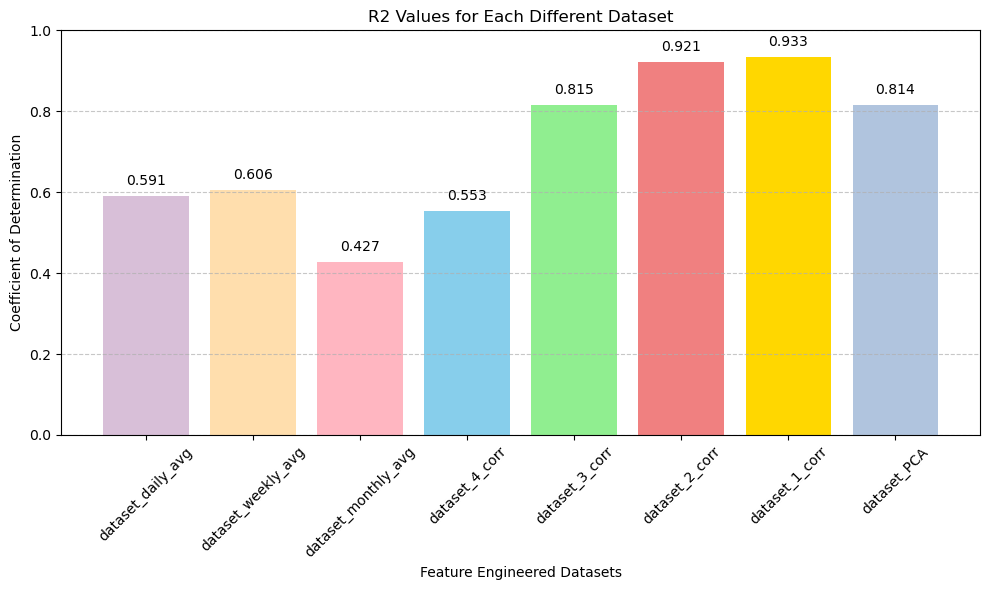

In [20]:
import matplotlib.pyplot as plt

# R2 values with corresponding datasets
r2_values = [0.590827237255393, 0.6055863370414064, 0.42650380346185496, 0.553011916910229,
              0.8153564656985636, 0.9208107171573804, 0.9331117781727114, 0.814417091786229]
datasets = ["dataset_daily_avg", "dataset_weekly_avg", "dataset_monthly_avg", "dataset_4_corr",
             "dataset_3_corr", "dataset_2_corr", "dataset_1_corr", "dataset_PCA"]
colors = ['thistle', 'navajowhite', 'lightpink', 'skyblue', 'lightgreen', 'lightcoral', 'gold', 'lightsteelblue']

# Create a bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(datasets, r2_values, color=colors)
plt.xlabel('Feature Engineered Datasets')
plt.ylabel('Coefficient of Determination')
plt.title('R2 Values for Each Different Dataset')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the R2 values on top of each bar
for bar, value in zip(bars, r2_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{value:.3f}', ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


As illustrated by the bar graph above, our most effective feature-engineered dataset was the one where we eliminated features with a correlation less than 0.05 to our label data (price actual). This dataset had the most features among all other refined datasets, with a total of 51 features. This was a surprise to us since our chosen base classifiers within our homogeneous ensemble, AdaBoosting and KNN Regression, are both known to be machine learning models that are susceptible to the curse of dimensionality. However, this made us realized that eliminating features by correlation was not beneficial in predicting Spain's energy price. This logically makes sense correlation does not equal causation. Therefore, it is reasonable to say that our model works best while containing a majority of the original dataset's features.  

Our worst feature-engineered datasets were the ones that were averaged/aggregated by day, week, and monthly. Moreover, these three datasets were the one's with the fewest features among all other datasets. Upon further exploration, AdaBoosting and KNN Regression are models that are sensitive to the distribution of data. That is, if the data is aggregated significantly, it could potentially cause the models to miss in capturing detailed patterns in our dataset. 
